In [70]:
import itertools
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import math
import sys
from pathlib import Path

sys.path.append('/media/data/robert/code/bids')
from bids_files import BIDS_FILE
import numpy as np
from nii_utils import calc_centroids, centroids_to_dict
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
#import SimpleITK as sitk
#from sitk_utils import affine_registration_transform,apply_transform
import ants

subreg_nib  = nib.load("vertebra_align/subreg.nii.gz")
vert_nib  = nib.load("vertebra_align/vert.nii.gz")
ct_nib  = nib.load("vertebra_align/ct.nii.gz")


arr = vert_nib.get_fdata().copy()
arr[arr != 0] += 1
vert_nib2  = nib.Nifti1Image(arr,vert_nib.affine)
arr2 = subreg_nib.get_fdata().copy()
arr2[arr == 0] = 0
subreg_nib2  = nib.Nifti1Image(arr2,vert_nib.affine)
#vert_nib2  = nib.load("vertebra_align/vert.nii.gz")
ct_nib2  = nib.load("vertebra_align/ct.nii.gz")

def compute_bbox(img:np.ndarray, pad=20):
    N = img.ndim
    out = []
    for ax in itertools.combinations(reversed(range(N)), N - 1):
        nonzero = np.any(img, axis=ax)
        out.extend(np.where(nonzero)[0][[0, -1]])
    bbox = list(out)
    for n in range(N):
        bbox[n*2+0] = max(0,bbox[n*2]-pad)
        bbox[n*2+1] = min(img.shape[n],bbox[n*2+1]+pad)
    return bbox

def compute_vertebra_bbox(vert_idx:int, seg: np.ndarray,imgs, pad=20)-> Option[sitk.Image]:
    if isinstance(seg,nib.Nifti1Image):
        seg = seg.get_fdata().copy()
        imgs = [i.get_fdata().copy() for i in imgs]
    else:
        seg = seg.copy()
        imgs = [i.copy() for i in imgs]
    seg[seg!=vert_idx] = 0
    bbox = compute_bbox(seg)
    seg = seg[bbox[0]:bbox[1],bbox[2]:bbox[3],bbox[4]:bbox[5]]
    imgs = [i[bbox[0]:bbox[1],bbox[2]:bbox[3],bbox[4]:bbox[5]] for i in imgs]
        #center = get_centroid(seg)
    #center = reversed(center)
    return seg, *imgs

def get_centroid(subregion_nii, id = 50):
    #if isinstance(subregion_nii,sitk.Image):
    #    subregion_nii = sitk.GetArrayFromImage(subregion_nii)
    #else:
    subregion_nii = subregion_nii.copy()
    subregion_nii[subregion_nii != id] = 0
    if subregion_nii.sum() == 0:
        return None
    return calc_centroids(nib.Nifti1Image(subregion_nii,subreg_nib.affine),decimals=100)[1][1:]
def dice(im1, im2):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)
    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")
    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)
    q = im1.sum() + im2.sum()
    if q == 0:
        return 1
    return 2.0 * intersection.sum() / q

def register_vertebras(subreg_nib: nib.Nifti1Image,vert_nib: nib.Nifti1Image,ct_nib: nib.Nifti1Image,subreg_nib2: nib.Nifti1Image,vert_nib2: nib.Nifti1Image,ct_nib2: nib.Nifti1Image,):
    for vert_idx in np.unique(vert_nib.get_fdata().astype(int))[4:]:
        if vert_idx == 0:
            continue
        print('[*] Test vertebra idx ', vert_idx)
        if vert_idx not in list(np.unique(vert_nib2.get_fdata().astype(int))):
            print('[*] Dice 0.00 (no match)')
            continue
        vert1,sub1,ct1 = compute_vertebra_bbox(vert_idx,vert_nib,[subreg_nib,ct_nib])
        vert2,sub2,ct2 = compute_vertebra_bbox(vert_idx,vert_nib2,[subreg_nib2,ct_nib2])

        sub1 = sub1*vert1/vert_idx
        sub2 = sub2*vert2/vert_idx
        
        centroid1 = get_centroid(sub1)
        centroid2 = get_centroid(sub2)
        
        if centroid1 is None:
            print('[*] Skip, reference vertebra centroid not inside image')
            continue
        if centroid2 is None:
            print('[*] Dice 0.00 (no centroid match)')
            continue
        
        #sub1 = sub1.astype(np.uint32)
        #sub2 = sub2.astype(np.uint32)
        fixed = ants.from_numpy(sub1,origin=centroid1)
        moving = ants.from_numpy(sub2,origin=centroid2)
        reg_out = ants.registration(fixed=fixed, moving=moving, type_of_transform="Rigid",interpolator="nearestNeighbor")
        #warped_moving = reg_out['warpedmovout'].numpy()
        warped_moving = ants.apply_transforms(fixed=fixed,moving=moving,transformlist=reg_out['fwdtransforms'],interpolator="nearestNeighbor")
        warped_moving = warped_moving.numpy()
        
        nib.save(
            nib.Nifti1Image(sub1.round(decimals=0), subreg_nib.affine),
            f"vertebra_align/{vert_idx}_o.nii.gz"
        )
        print(np.unique(warped_moving))
        nib.save(
            nib.Nifti1Image(warped_moving, subreg_nib.affine),
            f"vertebra_align/{vert_idx}_r.nii.gz"
        )
        #nib.save(
        #    nib.Nifti1Image(vert2, subreg_nib.affine),
        #    f"vertebra_align/{vert_idx}_u.nii.gz"
        #)
        #nib.save(
        #    nib.Nifti1Image(sub1, subreg_nib.affine),
        #    f"vertebra_align/{vert_idx}_u2.nii.gz"
        #)
        #nib.save(
        #    nib.Nifti1Image(sub2, subreg_nib.affine),
        #    f"vertebra_align/{vert_idx}_o2.nii.gz"
        #)
        
        vert1 = vert1.copy()
        vert1[vert1!=0] = 1
        warped_moving[warped_moving!=0] = 1
        d = dice(vert1,warped_moving)
        print(f'[*] Dice {d:.2f}')
        



        
#register_vertebras(subreg_nib,vert_nib,ct_nib,subreg_nib2,vert_nib2,ct_nib2)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[ 0.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15.]
[5, 165, 67, 107, 0, 52]


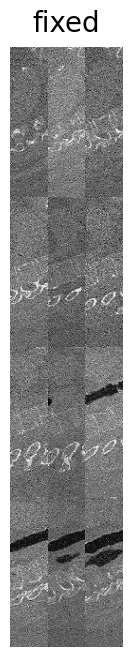

[5, 165, 67, 107, 0, 52]
[5, 165, 67, 107, 0, 52]


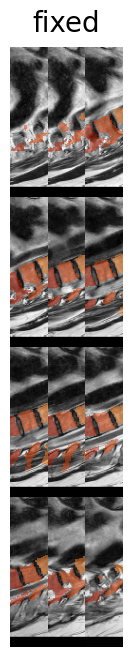

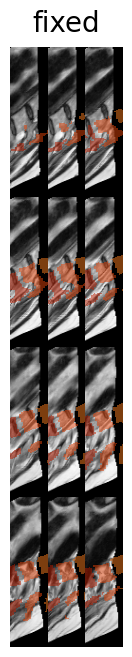

In [11]:
path = "/media/data/dataset-spinegan/register_test/registration_ohne_fix/spinegan0008/target-301_from-201"

centroid_nib  = nib.load(f"{path}/sub-spinegan0008_ses-20210204_sequ-301_reg-201_msk.nii.gz")
print(np.unique(centroid_nib.get_fdata()))
#mr_nib  = nib.load(f"{path}/sub-spinegan0008_ses-20210204_sequ-301_reg-201_acq-water_dixon.nii.gz")
#mr_nib  = nib.load(f"{path}/sub-spinegan0008_ses-20210204_sequ-301_reg-201_acq-fat_dixon.nii.gz")
mr_nib  = nib.load(f"{path}/sub-spinegan0008_ses-20210204_sequ-301_reg-201_acq-real_dixon.nii.gz")
ct_nib  = nib.load(f"{path}/sub-spinegan0008_ses-20210202_sequ-201_reg-301_ct.nii.gz")
vert_nib  = nib.load(f"{path}/sub-spinegan0008_ses-20210202_sequ-201_reg-301_seg-vert_msk.nii.gz")

centoird = get_centroid(centroid_nib.get_fdata(), 10)

def getCube(centoird, arr, pad=(40,10,50)):
    if isinstance(arr,nib.Nifti1Image):
        arr = arr.get_fdata().copy()
    bbox = []
    for c,p in zip(centoird,pad):
        bbox.append(round(c-p))
        bbox.append(round(c+p))
    for n in range(3):
        bbox[n*2+0] = max(0,bbox[n*2]-pad[n])
        bbox[n*2+1] = min(arr.shape[n],bbox[n*2+1]+pad[n])
    print(bbox)
    return arr[bbox[0]:bbox[1],bbox[2]:bbox[3],bbox[4]:bbox[5]].copy()
ct_arr = getCube(centoird,ct_nib)
#ct_arr[ct_arr<=0]=0
ct_arr -= np.min(ct_arr)
ct_arr /= np.max(ct_arr)
#fixed = ants.from_numpy(ct_arr.transpose(2,0,1)-ct_arr.min())
fixed = ants.from_numpy(ct_arr.transpose(1,0,2))
fixed.plot(title='fixed',axis=2)

vert_arr = getCube(centoird,vert_nib)
vert = ants.from_numpy(vert_arr.transpose(1,0,2))

mr_arr = getCube(centoird,mr_nib)
mr_arr /= np.max(mr_arr)
#mr_arr = 1- mr_arr
#fixed = ants.from_numpy(ct_arr.transpose(2,0,1)-ct_arr.min())
moving = ants.from_numpy(mr_arr.transpose(1,0,2))
moving.plot(title='fixed',overlay=vert,overlay_alpha=0.5,axis=2)


reg_out = ants.registration(fixed=vert, moving=moving, type_of_transform='SyN')
warped_moving:ants.ANTsImage = reg_out['warpedmovout']
#print(reg_out['fwdtransforms'])

#import scipy.io
#mat = scipy.io.loadmat(reg_out['fwdtransforms'][0])
#print(mat)
warped_moving.plot(title='fixed',overlay=vert,overlay_alpha=0.5,axis=2)

In [ ]:
#"Translation": Translation transformation.
#"Rigid": Rigid transformation: Only rotation and translation.
#"Similarity": Similarity transformation: scaling, rotation and translation.
#"QuickRigid": Rigid transformation: Only rotation and translation. May be useful for quick visualization fixes.'
#"DenseRigid": Rigid transformation: Only rotation and translation. Employs dense sampling during metric estimation.'
#"BOLDRigid": Rigid transformation: Parameters typical for BOLD to BOLD intrasubject registration'.'
#"Affine": Affine transformation: Rigid + scaling.
#"AffineFast": Fast version of Affine.
#"BOLDAffine": Affine transformation: Parameters typical for BOLD to BOLD intrasubject registration'.'
#"TRSAA": translation, rigid, similarity, affine (twice). please set regIterations if using this option. this would be used in cases where you want a really high quality affine mapping (perhaps with mask).
#"Elastic": Elastic deformation: Affine + deformable.
#"ElasticSyN": Symmetric normalization: Affine + deformable transformation, with mutual information as optimization metric and elastic regularization.
#"SyN": Symmetric normalization: Affine + deformable transformation, with mutual information as optimization metric.
#"SyNRA": Symmetric normalization: Rigid + Affine + deformable transformation, with mutual information as optimization metric.
#"SyNOnly": Symmetric normalization: no initial transformation, with mutual information as optimization metric. Assumes images are aligned by an inital transformation. Can be useful if you want to run an unmasked affine followed by masked deformable registration.
#"SyNCC": SyN, but with cross-correlation as the metric.
#"SyNabp": SyN optimized for abpBrainExtraction.
#"SyNBold": SyN, but optimized for registrations between BOLD and T1 images.
#"SyNBoldAff": SyN, but optimized for registrations between BOLD and T1 images, with additional affine step.
#"SyNAggro": SyN, but with more aggressive registration (fine-scale matching and more deformation). Takes more time than SyN.
#"TV[n]": time-varying diffeomorphism with where 'n' indicates number of time points in velocity field discretization. The initial transform should be computed, if needed, in a separate call to ants.registration.
#"TVMSQ": time-varying diffeomorphism with mean square metric
#"TVMSQC": time-varying diffeomorphism with mean square metric for very large deformation
#"antsRegistrationSyN[x]": recreation of the antsRegistrationSyN.sh script in ANTs where 'x' is one of the transforms available (e.g., 't', 'b', 's')
#"antsRegistrationSyNQuick[x]": recreation of the antsRegistrationSyNQuick.sh script in ANTs where 'x' is one of the transforms available (e.g., 't', 'b', 's')
#"antsRegistrationSyNRepro[x]": reproducible registration. x options as above.
#"antsRegistrationSyNQuickRepro[x]": quick reproducible registration. x options as above

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
[111.5, 113.49999999999999, 23.0]
[148.37727036844836, 124.48105864037363, 18.50492994291645]
(52, 188)


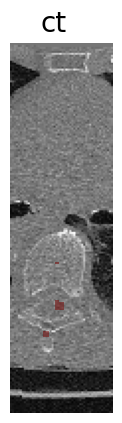

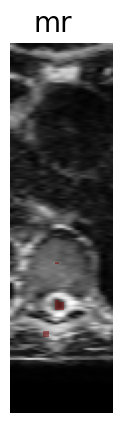

In [61]:
import itertools
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import math
import sys
from pathlib import Path

sys.path.append('/media/data/robert/code/bids')
from bids_files import BIDS_FILE
import numpy as np
from nii_utils import calc_centroids, centroids_to_dict
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
#import SimpleITK as sitk
#from sitk_utils import affine_registration_transform,apply_transform
import ants

path = "/media/data/dataset-spinegan/register_test/registration/spinegan0007/target-302_from-201"

ct_nib  = nib.load(f"{path}/sub-spinegan0007_ses-20210910_sequ-201_reg-302_ct.nii.gz")
mr_nib  = nib.load(f"{path}/sub-spinegan0007_ses-20210913_sequ-302_reg-201_acq-real_dixon.nii.gz")
centroids_nib  = nib.load(f"{path}/sub-spinegan0007_ses-20210913_sequ-302_reg-201_msk.nii.gz")
cord_nib  = nib.load(f"{path}/sub-spinegan0007_ses-20210913_sequ-302_reg-201_label-spinalcord_msk.nii.gz")
sub_nib  = nib.load(f"{path}/sub-spinegan0007_ses-20210910_sequ-201_reg-302_seg-subreg_msk.nii.gz")
vert_nib  = nib.load(f"{path}/sub-spinegan0007_ses-20210910_sequ-201_reg-302_seg-vert_msk.nii.gz")

centroid_index = 15



centoird = get_centroid(centroids_nib.get_fdata(), centroid_index)
sub_arr = sub_nib.get_fdata().copy()
vert_arr = vert_nib.get_fdata().copy()
sub_arr[vert_arr!=centroid_index] =0

dorn = get_centroid(sub_arr,42)

print(centoird)
print(dorn)
def getSlice(arr, idx, axis=-1, flatten = False)-> tuple[np.ndarray,ants.ANTsImage]:
    if isinstance(arr,nib.Nifti1Image):
        arr = arr.get_fdata().copy()
    arr -= np.min(arr)
    arr /= np.max(arr)
    if flatten:
        arr[arr!=0] = 1
    arr: np.ndarray
    arr = arr[:,idx].transpose(1,0)
    return arr,ants.from_numpy(arr)

slice_idx = int(centoird[1])
ct_arr, ct_ant = getSlice(ct_nib,slice_idx)
mr_arr, mr_ant = getSlice(mr_nib,slice_idx)
ce_arr, ce_ant = getSlice(centroids_nib,slice_idx,flatten=True)
#print(np.where(ce_arr))
cord_arr, cord_ant = getSlice(cord_nib,slice_idx,flatten=True)
sub_arr, sub_ant = getSlice(sub_nib,slice_idx,flatten=False)
print(cord_arr.shape)
cord_arr[int(dorn[2])-2:int(dorn[2])+2,int(dorn[0])-2:int(dorn[0])+2] = 1
cord_ant = ants.from_numpy(cord_arr)

ct_ant.plot(title='ct',overlay=cord_ant+ce_ant,overlay_alpha=0.5,axis=2,dpi=200)
mr_ant.plot(title='mr',overlay=cord_ant+ce_ant,overlay_alpha=0.5,axis=2,dpi=200)





In [75]:
centoird2 = (centoird[0],centoird[2],)
dorn2 = (dorn[0],dorn[2],)

length = math.sqrt(sum([(b-a)*(b-a) for a,b in zip(centoird2,dorn2)]))

print(centoird2)
print(dorn2)
print(length)
inter = [a+10*(b-a)/length for a,b in zip(centoird2,dorn2)]
print(inter)
length2 = math.sqrt(sum([(b-a)*(b-a) for a,b in zip(centoird2,inter)]))
print(length2)

(111.5, 23.0)
(148.37727036844836, 18.50492994291645)
37.15021836605713
[121.42652856171145, 21.79002863111283]
9.999999999999995


In [76]:
import nibabel.orientations as nio
axc = nio.aff2axcodes(sub_nib.affine)

In [77]:
axc

('P', 'I', 'R')